In [2]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import sys
GeoPy_path='/home/shashank/nobackup_shashank/gslib_executables/GeostatsPy/'
sys.path.insert(0, GeoPy_path)
import GeostatsPy
import os
import rasterio 
from scipy import stats
from IPython.display import Image
from pygeotools.lib import  iolib,geolib,warplib,malib

In [3]:
#Data_Files are 2 km buffer dh and the latest mb_csv to get the glacier area
csv_fn='mb_20181108-20181111T192508Z-001/mb_20181108/hma_mb_20181108_0454.csv'
df=pd.read_csv(csv_fn)
datapath='/home/shashank/nobackup_shashank/HMA_Mb_Analysis/reprocessed_data/mb_20181108-20181111T192508Z-001/mb_20181108/test_glaciers/'
fn_list=[]
fl=[]
for file in os.listdir(datapath):
    fn_name=os.fsdecode(file)
    if fn_name.endswith('static.tif'):
        fl.append(fn_name.split('_')[0])
        fn_list.append(os.path.join(datapath,fn_name))

In [17]:
ma_list=[iolib.fn_getma(i) for i in fn_list]
gt_list=[iolib.fn_getds(i).GetGeoTransform() for i in fn_list]

In [14]:
def get_xyz(ma,gt,z):
    """
    Takes in a masked array gdal style gt & header for z
        
        returns a dataframe containing the x,y and the value of the raster
    """
    x,y=geolib.get_xy_ma(ma,gt,origmask=True)
    xyz=np.vstack((x.compressed(),y.compressed(),ma.compressed())).T
    df=pd.DataFrame(xyz,columns=['x','y',z])
    return(df)

In [9]:
def model_param(var,lag,gamma):
    """
     model for a spherical variogram, assuming sill at the variance of the data
     Takes in the variance, lag and gamma returned by GSLIB
     Returns sill,range and nugget
    """
    sill=var
    print('Sill=',sill)
    idx=np.argmax(np.array(gamma)>sill)
    print(idx)
    vrange=lag[idx]
    print("Range =",vrange)
    x=lag[0:4]
    y=gamma[0:4]
    slope,nugget,r,p,std=stats.linregress(x,y)
    print("Nugget=",nugget)
    return (sill,vrange,nugget)

In [10]:
def vario_plt(lag,gamma,lag_m,gamma_m,hrange,rgi_title):
    """
    Simple Plotting function for variogram and modlled variogram
    """
    fig,ax=plt.subplots(figsize=(8,8))
    ax.plot(lag,gamma,'r--')
    ax.plot(lag_m,gamma_m,'g^')
    ax.vline(x=hrange,color='blue',ymin=0,ymax=np.max(np.array(gamma)))
    ax.set_xlabel('Lag Distance (m)')
    ax.set_ylabel('Variogram')
    ax.set_title(rgi_title)
    return fig
    

In [11]:
def variogram(rgi_title,df,x,y,val,nlag,lag,azi=0,tol=90,bstand=0):
    """
    Takes in a dataframe containing a x,y and values, variogram properties such as number of lags, lag distance,
    azimuth,azimuth tolerance and argument to standardize the sill or not
    
    Calulates variogram, which is then modelled for a spherical variogram, assuming sill at the variance of the data
    
    By Default calculates the omnidirectional varigram
    Calls in the variogram plotting function and plots the modelled and experimental variogram
    
    Returns the distance of autocorrelation and saves the plot
    """
    lag,gamma,npair=GeostatsPy.gamv_2d(df,x,y,val,nlag,lag,azi,tol,bstand)
    sill,hrange,c0=model_param(np.var(df[val]),lag,gamma)
    lag_m,gamma_m=GeostatsPy.vmodel_2d(nlag,lag,azi,c0,1,1,sill,azi,hrange,1)
    fig=vario_plt(lag,gamma,lag_m,gamma_m,hrange,rgi_title)
    fig_name=rgi_title+" variogram.png"
    fig.savefig(fig_name,dpi=300)
    return hrange
    

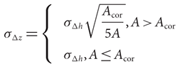

In [12]:
Image('Brun.gif')

In [13]:
def dh_er(ma,hrange,df,rgi_title):
    std=malib.print_stats(ma)[4]
    nmad=malib.print_stats(ma)[6]
    a_cor=np.pi*(hrange*hrange)
    a=(df.loc[df['RGIId']==rgi_title]).area_m2.value[0]
    if a>a_cor:
        sig_dh=std*np.sqrt(a_cor/(5*a))
    else:
        sig_dh=std
    print('dh_error =',sig_dh)
    return std,nmad,sig_dh
        

In [15]:
dh_df=get_xyz(ma_list[0],gt_list[0],'dh')

Sill= 39.672841817387294
20
Range = 486.772
Nugget= -0.10917217269704294


AttributeError: 'AxesSubplot' object has no attribute 'vline'

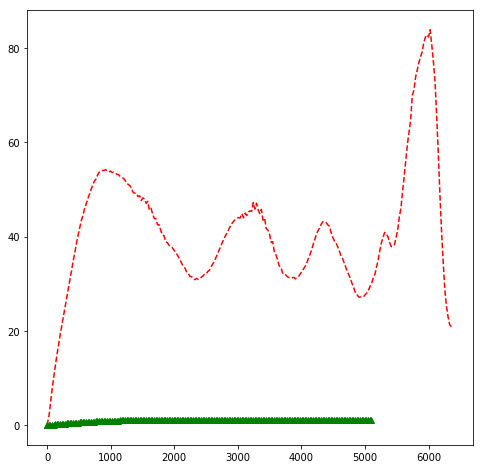

In [20]:
hrange=variogram(fl[0],dh_df,'x','y','dh',250,gt_list[0][1])

In [19]:
gt_list[0][1]

25.531882649227317